In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDHQ0J7/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDHQ0J7/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


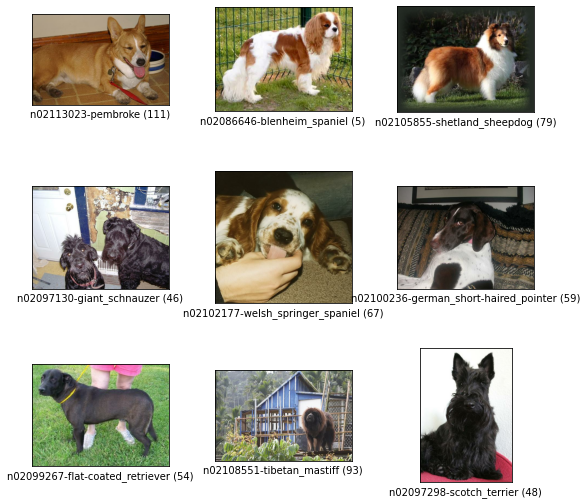

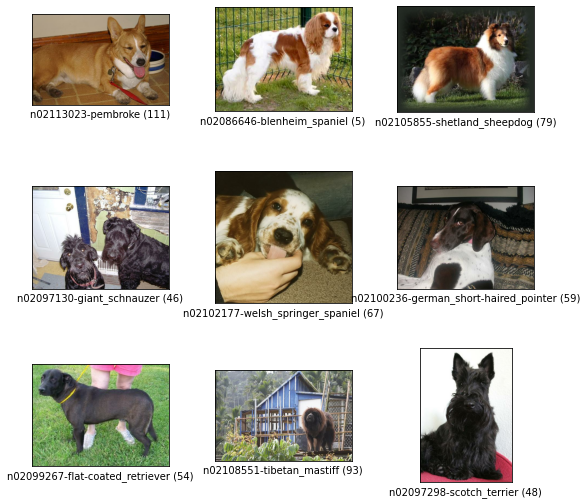

In [4]:
tfds.show_examples(ds_train, ds_info)

1-2. Augmentation (기본)
Tensorflow Random Augmentation API 사용

random_brightness()
random_contrast()
random_crop()
random_flip_left_right()
random_flip_up_down()
random_hue()
random_jpeg_quality()
random_saturation()

In [5]:
# 전처리 함수
def normalize_and_resize_img(image, label): # 변환할 이미지와 라벨 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 변화
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2 # 병렬처리 수준 지정
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  
    #tf.data.experimental.AUTOTUNE: 어떤 수준의 병렬처리가 tf.data  런타임에 사용되는지 결정
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [9]:
num_classes = ds_info.features["label"].num_classes

1-3. Augmentation(Cutmix)
CutMix: Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법
이미지 섞기
바운딩 박스(bounding box): 이미지에서 잘라서 섞어주는 영역
바운딩 박스의 위치를 랜덤하게 뽑고 잘라내서 두 개의 이미지를 섞어줌
라벨 섞기
CutMix에서는 면적에 비례해서 라벨을 섞는다.
라벨 벡터는 각 클래스에 해당하는 인덱스에 적절한 비율을 배분하는 방식 사용

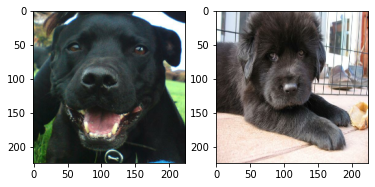

In [10]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [12]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(25, shape=(), dtype=int32)
y :  tf.Tensor(81, shape=(), dtype=int32) tf.Tensor(183, shape=(), dtype=int32)


In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

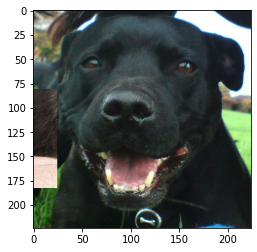

In [14]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [15]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [16]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.9491789 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [17]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1-4. Mixup Augmentation
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑는다.
해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [18]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

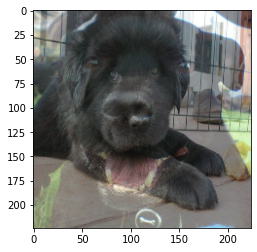

In [19]:
mixed_img2, mixed_label2 = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img2.numpy())
plt.show()

In [20]:
print(mixed_label2)

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.5133865 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4866135 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

1-5. 데이터셋 제작하기
cutmix, mixup augmentation이 적용 가능하도록 apply_normalize_on_dataset 함수 수정

In [22]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label
    
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [23]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


2. 모델 만들기

2-1. ResNet50 (No augmentation)

In [24]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])



94781440/94765736 [==============================] - 1s 0us/step


In [25]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [26]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


3. 모델 훈련하기
3-1. ResNet50 (No augmentation

In [28]:
EPOCH = 20

In [29]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [30]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)


aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [31]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 104s 118ms/step - loss: 2.1882 - accuracy: 0.4499 - val_loss: 3.5785 - val_accuracy: 0.1772
Epoch 2/20
750/750 [==============================] - 87s 115ms/step - loss: 0.7462 - accuracy: 0.7923 - val_loss: 1.0837 - val_accuracy: 0.6819
Epoch 3/20
750/750 [==============================] - 87s 115ms/step - loss: 0.2271 - accuracy: 0.9526 - val_loss: 0.9174 - val_accuracy: 0.7358
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0587 - accuracy: 0.9956 - val_loss: 0.9077 - val_accuracy: 0.7403
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0206 - accuracy: 0.9994 - val_loss: 0.9009 - val_accuracy: 0.7424
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0131 - accuracy: 0.9998 - val_loss: 0.9131 - val_accuracy: 0.7421
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.9214 - val_a

In [36]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 89s 114ms/step - loss: 0.3074 - accuracy: 0.9243 - val_loss: 1.0452 - val_accuracy: 0.6994
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.2030 - accuracy: 0.9523 - val_loss: 1.0424 - val_accuracy: 0.7038
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1105 - accuracy: 0.9821 - val_loss: 1.0008 - val_accuracy: 0.7228
Epoch 4/20
750/750 [==============================] - 87s 115ms/step - loss: 0.0655 - accuracy: 0.9909 - val_loss: 1.0205 - val_accuracy: 0.7199
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0426 - accuracy: 0.9951 - val_loss: 1.0161 - val_accuracy: 0.7291
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0348 - accuracy: 0.9962 - val_loss: 1.0819 - val_accuracy: 0.7156
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0566 - accuracy: 0.9908 - val_loss: 1.0708 - val_ac

In [37]:
history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 91s 118ms/step - loss: 2.4033 - accuracy: 0.6102 - val_loss: 1.2726 - val_accuracy: 0.6564
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.2675 - accuracy: 0.6556 - val_loss: 1.4691 - val_accuracy: 0.5964
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1668 - accuracy: 0.6817 - val_loss: 1.2978 - val_accuracy: 0.6556
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.0553 - accuracy: 0.7160 - val_loss: 1.2919 - val_accuracy: 0.6653
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 1.9892 - accuracy: 0.7358 - val_loss: 1.2523 - val_accuracy: 0.6720
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 1.9022 - accuracy: 0.7592 - val_loss: 1.3008 - val_accuracy: 0.6638
Epoch 7/20
750/750 [==============================] - 88s 118ms/step - loss: 1.8688 - accuracy: 0.7728 - val_loss: 1.2855 - val_ac

In [ ]:
history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 91s 118ms/step - loss: 2.5608 - accuracy: 0.5939 - val_loss: 1.4527 - val_accuracy: 0.5983
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.3948 - accuracy: 0.6543 - val_loss: 1.4266 - val_accuracy: 0.6137
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 2.2464 - accuracy: 0.7057 - val_loss: 1.3537 - val_accuracy: 0.6295
Epoch 4/20
653/750 [=========================>....] - ETA: 9s - loss: 2.1576 - accuracy: 0.7465


4. 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화

4-1. Accuracy (val)

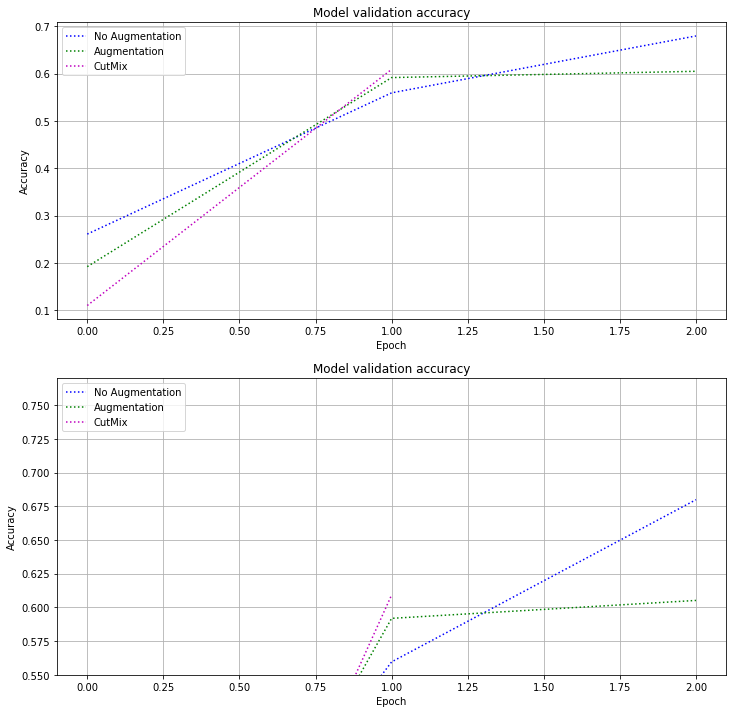

In [35]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.770)   

plt.show()

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.